<a href="https://colab.research.google.com/github/frankwillard/Basketball-Advanced-Stats-Web-Scraper/blob/main/TensorFlow_NBA_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow NBA Champion Neural Network

### Importing the libraries

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [17]:
tf.__version__

'2.8.0'

## Part 1 - Data Preprocessing

### Importing the dataset

In [18]:
dataset = pd.read_csv('nba_team_advanced_data.csv')
dataset.head()

,Year,Team,Age,W,L,PW,PL,MOV,SOS,SRS,...,DRB%,DFT/FGA,Arena,Attend.,Playoffs,W/L%,Losing_season,Champion,won_last,won_last_3
0,1990.0,Atlanta Hawks,28.6,41.0,41.0,44.0,38.0,1.02,-0.39,0.64,...,65.5,0.254,Omni Coliseum,573711.0,N,0.500000,N,N,N,N
1,1990.0,Boston Celtics,30.2,52.0,30.0,51.0,31.0,3.99,-0.76,3.23,...,72.1,0.223,Boston Garden,611537.0,N,0.634146,N,N,N,N
2,1990.0,Charlotte Hornets,25.6,19.0,63.0,21.0,61.0,-7.82,0.81,-7.00,...,67.5,0.269,Charlotte Coliseum,979941.0,N,0.231707,Y,N,N,N
3,1990.0,Chicago Bulls,26.1,55.0,27.0,50.0,32.0,3.26,-0.51,2.74,...,68.1,0.262,Chicago Stadium,752564.0,N,0.670732,N,N,N,N
4,1990.0,Cleveland Cavaliers,26.1,42.0,40.0,40.0,42.0,-0.30,-0.31,-0.62,...,67.7,0.202,Coliseum at Richfield,695710.0,N,0.512195,N,N,N,N


In [19]:
dataset = dataset.drop(columns=['Playoffs', 'Losing_season', 'Arena'])

In [20]:
dataset.columns

Index(['Year', 'Team', 'Age', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS',
       'ORtg', 'DRtg', 'NRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'OeFG%', 'OTOV%',
       'ORB%', 'OFT/FGA', 'DeFG%', 'DTOV%', 'DRB%', 'DFT/FGA', 'Attend.',
       'W/L%', 'Champion', 'won_last', 'won_last_3'],
      dtype='object')

In [21]:
#Drop Year, Champion, Team
X = dataset.iloc[:, ~ dataset.columns.isin(['Year', 'Champion', 'Team'])]
y = dataset.loc[:, dataset.columns == 'Champion'].values
y = np.array([0 if val == "N" else 1 for val in y])

### Identifying Class Imbalance

In [22]:
neg, pos = np.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 903
    Positive: 31 (3.43% of total)



### Encode Categorical Values

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
#3 because want to one hot encode State variable
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['won_last', 'won_last_3'])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

### Splitting the dataset into the Training set and Test set

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y,train_size=0.7, test_size=0.25, random_state=7)

### Feature Scaling

In [26]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
#X_test = sc.transform(X_test)

In [27]:
print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)

Training labels shape: (632,)
Validation labels shape: (226,)
Training features shape: (632, 29)
Validation features shape: (226, 29)


## Part 2 - Building the Baseline ANN

### Setting Model Hyperparameters

In [38]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [39]:
opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
input_shape = X_train.shape[-1]

In [ ]:
#!pip install tensorflow_addons
#import tensorflow_addons as tfa
#fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.0001, gamma=2.0)

In [40]:
tf.random.set_seed(0)

### Building the Model

In [41]:
def create_model(input_shape = input_shape, metrics=METRICS, optimizer= opt, loss_function = loss, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  ann = tf.keras.models.Sequential()
  ann.add(tf.keras.layers.Dense(input_shape = (input_shape, ), units=200, activation='relu'))
  ann.add(tf.keras.layers.BatchNormalization())
  ann.add(tf.keras.layers.Dropout(0.4))
  ann.add(tf.keras.layers.Dense(units=100, activation='relu'))
  ann.add(tf.keras.layers.BatchNormalization())
  ann.add(tf.keras.layers.Dropout(0.4))
  ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid', bias_initializer = output_bias))
  ann.compile(optimizer = opt, loss = loss_function, metrics=metrics)
  return ann

## Part 3 - Training the ANN

In [42]:
EPOCHS = 200
BATCH_SIZE = 16
val_data = (X_val, y_val)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_prc", 
                                        mode ="max", patience = 5, 
                                        restore_best_weights = True)

In [43]:
initial_bias = np.log([pos/neg])

In [44]:
model = create_model(output_bias = initial_bias)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 200)               6000      
                                                                 
 batch_normalization_4 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_7 (Dense)             (None, 100)               20100     
                                                                 
 batch_normalization_5 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 100)              

In [45]:
import tempfile
import os

In [46]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [47]:
model = create_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=val_data, 
    verbose=0)

In [48]:
model = create_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=val_data, 
    verbose=0)

In [49]:
import matplotlib.pyplot as plt

In [50]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [51]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

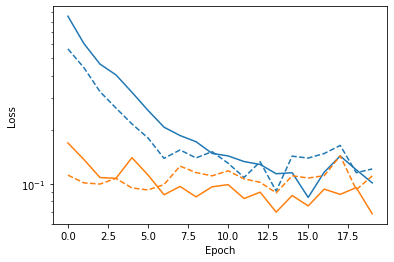

In [52]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [54]:
model = create_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[earlystopping],
    validation_data=val_data)

Epoch 1/200
40/40 [==============================] - 8s 57ms/step - loss: 0.1575 - tp: 5.0000 - fp: 21.0000 - tn: 808.0000 - fn: 24.0000 - accuracy: 0.9476 - precision: 0.1923 - recall: 0.1724 - auc: 0.8551 - prc: 0.2119 - val_loss: 0.1004 - val_tp: 1.0000 - val_fp: 5.0000 - val_tn: 216.0000 - val_fn: 4.0000 - val_accuracy: 0.9602 - val_precision: 0.1667 - val_recall: 0.2000 - val_auc: 0.8864 - val_prc: 0.2762
Epoch 2/200
40/40 [==============================] - 0s 5ms/step - loss: 0.1482 - tp: 5.0000 - fp: 8.0000 - tn: 600.0000 - fn: 19.0000 - accuracy: 0.9573 - precision: 0.3846 - recall: 0.2083 - auc: 0.8114 - prc: 0.2171 - val_loss: 0.1020 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 219.0000 - val_fn: 4.0000 - val_accuracy: 0.9735 - val_precision: 0.3333 - val_recall: 0.2000 - val_auc: 0.8747 - val_prc: 0.2656
Epoch 3/200
40/40 [==============================] - 0s 5ms/step - loss: 0.1233 - tp: 6.0000 - fp: 10.0000 - tn: 598.0000 - fn: 18.0000 - accuracy: 0.9557 - precision: 0.3750

In [55]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

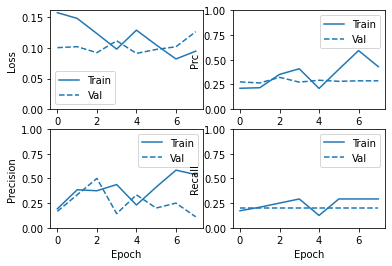

In [56]:
plot_metrics(baseline_history)

In [57]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_val, batch_size=BATCH_SIZE)

In [63]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [64]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.09223031252622604
tp :  1.0
fp :  1.0
tn :  220.0
fn :  4.0
accuracy :  0.9778761267662048
precision :  0.5
recall :  0.20000000298023224
auc :  0.8882352709770203
prc :  0.32219281792640686

Legitimate Transactions Detected (True Negatives):  220
Legitimate Transactions Incorrectly Detected (False Positives):  1
Fraudulent Transactions Missed (False Negatives):  4
Fraudulent Transactions Detected (True Positives):  1
Total Fraudulent Transactions:  5


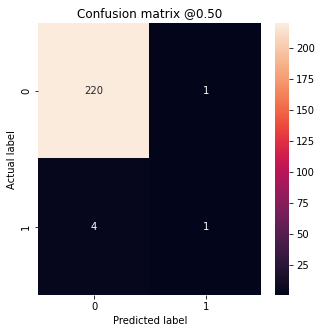

In [65]:
baseline_results = model.evaluate(X_val, y_val,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_val, test_predictions_baseline)

In [66]:
import sklearn

In [77]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([50,100.5])
  plt.grid(True)
  ax = plt.gca()
  #ax.set_aspect('equal')

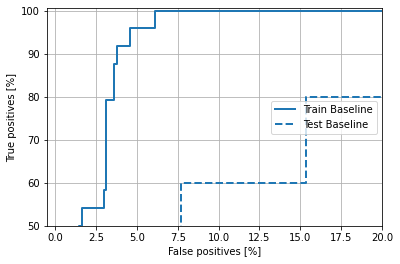

In [78]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='center right');

In [81]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

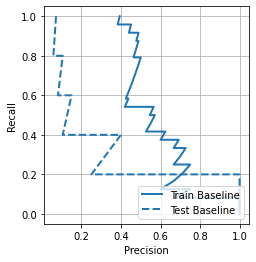

In [82]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

## Class weights

In [83]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.52
Weight for class 1: 14.56


In [85]:
weighted_model = create_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[earlystopping],
    validation_data=val_data,
    # The class weights go here
    class_weight=class_weight)

Epoch 1/200
40/40 [==============================] - 6s 30ms/step - loss: 0.5016 - tp: 19.0000 - fp: 81.0000 - tn: 748.0000 - fn: 10.0000 - accuracy: 0.8939 - precision: 0.1900 - recall: 0.6552 - auc: 0.8972 - prc: 0.2430 - val_loss: 0.4081 - val_tp: 4.0000 - val_fp: 43.0000 - val_tn: 178.0000 - val_fn: 1.0000 - val_accuracy: 0.8053 - val_precision: 0.0851 - val_recall: 0.8000 - val_auc: 0.9086 - val_prc: 0.2250
Epoch 2/200
40/40 [==============================] - 0s 6ms/step - loss: 0.7027 - tp: 18.0000 - fp: 100.0000 - tn: 508.0000 - fn: 6.0000 - accuracy: 0.8323 - precision: 0.1525 - recall: 0.7500 - auc: 0.8630 - prc: 0.2658 - val_loss: 0.5776 - val_tp: 3.0000 - val_fp: 44.0000 - val_tn: 177.0000 - val_fn: 2.0000 - val_accuracy: 0.7965 - val_precision: 0.0638 - val_recall: 0.6000 - val_auc: 0.8652 - val_prc: 0.0925
Epoch 3/200
40/40 [==============================] - 0s 4ms/step - loss: 0.3805 - tp: 22.0000 - fp: 104.0000 - tn: 504.0000 - fn: 2.0000 - accuracy: 0.8323 - precision: 

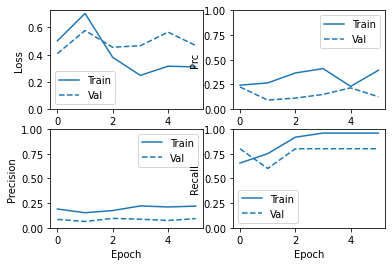

In [86]:
plot_metrics(weighted_history)

In [88]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_val, batch_size=BATCH_SIZE)

loss :  0.40811657905578613
tp :  4.0
fp :  43.0
tn :  178.0
fn :  1.0
accuracy :  0.8053097128868103
precision :  0.08510638028383255
recall :  0.800000011920929
auc :  0.9085972309112549
prc :  0.2249782532453537

Legitimate Transactions Detected (True Negatives):  178
Legitimate Transactions Incorrectly Detected (False Positives):  43
Fraudulent Transactions Missed (False Negatives):  1
Fraudulent Transactions Detected (True Positives):  4
Total Fraudulent Transactions:  5


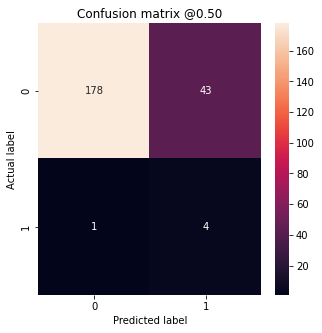

In [89]:
weighted_results = weighted_model.evaluate(X_val, y_val,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_val, test_predictions_weighted)

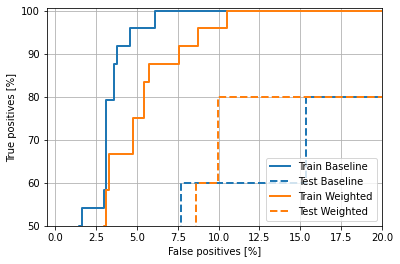

In [90]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_val, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

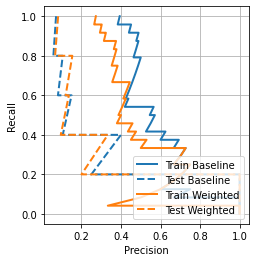

In [91]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_val, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

In [94]:
bool_train_labels = y_train != 0

In [95]:
pos_X_train = X_train[bool_train_labels]
neg_X_train = X_train[~bool_train_labels]

pos_y_train = y_train[bool_train_labels]
neg_y_train = y_train[~bool_train_labels]

In [97]:
ids = np.arange(len(pos_X_train))
choices = np.random.choice(ids, len(neg_X_train))

res_pos_X_train = pos_X_train[choices]
res_pos_y_train = pos_y_train[choices]

res_pos_X_train.shape

(608, 29)

In [98]:
resampled_features = np.concatenate([res_pos_X_train, neg_X_train], axis=0)
resampled_labels = np.concatenate([res_pos_y_train, neg_y_train], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(1216, 29)

In [99]:
resampled_model = create_model()
resampled_model.load_weights(initial_weights)

In [100]:
# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

In [101]:
val_ds = tf.data.Dataset.from_tensor_slices(val_data).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

In [102]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)

In [103]:
resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[earlystopping],
    validation_data=val_ds)

Epoch 1/200
109/109 [==============================] - 4s 12ms/step - loss: 0.3667 - tp: 577.0000 - fp: 151.0000 - tn: 722.0000 - fn: 76.0000 - accuracy: 0.8512 - precision: 0.7926 - recall: 0.8836 - auc: 0.9268 - prc: 0.8844 - val_loss: 0.7270 - val_tp: 4.0000 - val_fp: 51.0000 - val_tn: 170.0000 - val_fn: 1.0000 - val_accuracy: 0.7699 - val_precision: 0.0727 - val_recall: 0.8000 - val_auc: 0.8864 - val_prc: 0.1481
Epoch 2/200
109/109 [==============================] - 0s 3ms/step - loss: 0.1980 - tp: 626.0000 - fp: 54.0000 - tn: 584.0000 - fn: 36.0000 - accuracy: 0.9308 - precision: 0.9206 - recall: 0.9456 - auc: 0.9725 - prc: 0.9576 - val_loss: 0.4349 - val_tp: 4.0000 - val_fp: 34.0000 - val_tn: 187.0000 - val_fn: 1.0000 - val_accuracy: 0.8451 - val_precision: 0.1053 - val_recall: 0.8000 - val_auc: 0.8760 - val_prc: 0.3795
Epoch 3/200
109/109 [==============================] - 0s 4ms/step - loss: 0.1921 - tp: 613.0000 - fp: 54.0000 - tn: 613.0000 - fn: 20.0000 - accuracy: 0.9431 - p

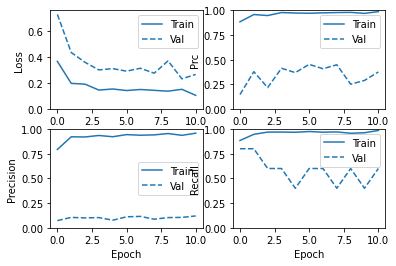

In [104]:
plot_metrics(resampled_history)

In [105]:
resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,    
    steps_per_epoch=20,# These are not real epochs
    epochs=10*EPOCHS,
    callbacks=[earlystopping],
    validation_data=(val_ds))

Epoch 1/2000
20/20 [==============================] - 0s 10ms/step - loss: 0.0977 - tp: 606.0000 - fp: 31.0000 - tn: 577.0000 - fn: 2.0000 - accuracy: 0.9729 - precision: 0.9513 - recall: 0.9967 - auc: 0.9915 - prc: 0.9845 - val_loss: 0.2942 - val_tp: 3.0000 - val_fp: 24.0000 - val_tn: 197.0000 - val_fn: 2.0000 - val_accuracy: 0.8850 - val_precision: 0.1111 - val_recall: 0.6000 - val_auc: 0.8864 - val_prc: 0.3375
Epoch 2/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0887 - tp: 607.0000 - fp: 25.0000 - tn: 583.0000 - fn: 1.0000 - accuracy: 0.9786 - precision: 0.9604 - recall: 0.9984 - auc: 0.9902 - prc: 0.9843 - val_loss: 0.2987 - val_tp: 3.0000 - val_fp: 24.0000 - val_tn: 197.0000 - val_fn: 2.0000 - val_accuracy: 0.8850 - val_precision: 0.1111 - val_recall: 0.6000 - val_auc: 0.8878 - val_prc: 0.3521
Epoch 3/2000
20/20 [==============================] - 0s 11ms/step - loss: 0.0805 - tp: 605.0000 - fp: 29.0000 - tn: 579.0000 - fn: 3.0000 - accuracy: 0.9737 - precisi

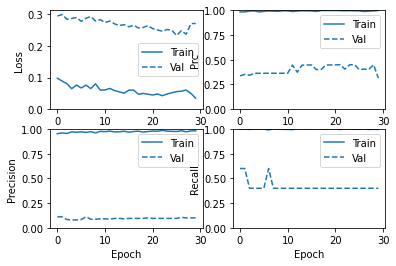

In [106]:
plot_metrics(resampled_history)


In [108]:
train_predictions_resampled = resampled_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_val, batch_size=BATCH_SIZE)

loss :  0.24885882437229156
tp :  2.0
fp :  19.0
tn :  202.0
fn :  3.0
accuracy :  0.9026548862457275
precision :  0.095238097012043
recall :  0.4000000059604645
auc :  0.8330317139625549
prc :  0.4502110779285431

Legitimate Transactions Detected (True Negatives):  202
Legitimate Transactions Incorrectly Detected (False Positives):  19
Fraudulent Transactions Missed (False Negatives):  3
Fraudulent Transactions Detected (True Positives):  2
Total Fraudulent Transactions:  5


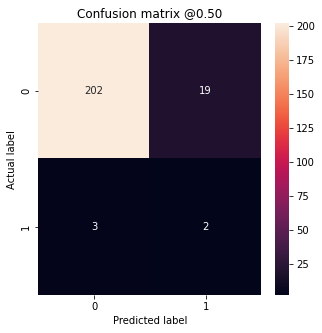

In [109]:
resampled_results = resampled_model.evaluate(X_val, y_val,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y_val, test_predictions_resampled)

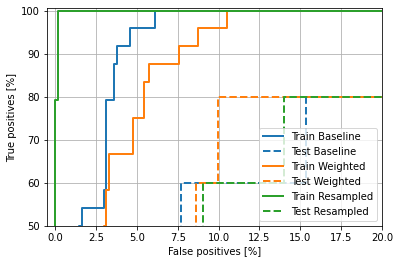

In [110]:

plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_val, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", y_train, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", y_val, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

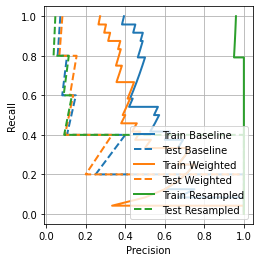

In [111]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_val, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", y_train, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", y_val, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

In [125]:
y_pred = resampled_model.predict(sc.transform(X))
test_output = np.column_stack([dataset["Year"], dataset["Team"], y_pred.flatten(), y])

In [126]:
test_df = pd.DataFrame(test_output, columns = ['Year', 'Team', 'Prediction', 'True'])

In [130]:
test_df[test_df["True"] == 1]

,Year,Team,Prediction,True
7,1990.0,Detroit Pistons,0.994917,1
30,1991.0,Chicago Bulls,0.997226,1
57,1992.0,Chicago Bulls,0.999743,1
84,1993.0,Chicago Bulls,0.997227,1
117,1994.0,Houston Rockets,0.994435,1
144,1995.0,Houston Rockets,0.996245,1
165,1996.0,Chicago Bulls,0.99951,1
194,1997.0,Chicago Bulls,0.999777,1
223,1998.0,Chicago Bulls,0.993178,1
272,1999.0,San Antonio Spurs,0.998932,1


In [135]:
test_df[test_df["Prediction"] > 0.5]

,Year,Team,Prediction,True
7,1990.0,Detroit Pistons,0.994917,1
30,1991.0,Chicago Bulls,0.997226,1
34,1991.0,Detroit Pistons,0.964528,0
57,1992.0,Chicago Bulls,0.999743,1
84,1993.0,Chicago Bulls,0.997227,1
117,1994.0,Houston Rockets,0.994435,1
144,1995.0,Houston Rockets,0.996245,1
165,1996.0,Chicago Bulls,0.99951,1
171,1996.0,Houston Rockets,0.979409,0
194,1997.0,Chicago Bulls,0.999777,1


In [175]:
years = np.arange(1990.0,2020.0)

row_list = []

for year in years:

  year_df = test_df[test_df["Year"] == year]
  year_df.reset_index()
  max_idx = pd.to_numeric(year_df["Prediction"]).idxmax()
  row_list.append(dict(test_df.iloc[max_idx]))

max_year_df = pd.DataFrame(row_list, columns = ['Year', 'Team', 'Prediction', 'True'])


In [176]:
max_year_df

,Year,Team,Prediction,True
0,1990.0,Detroit Pistons,0.994917,1
1,1991.0,Chicago Bulls,0.997226,1
2,1992.0,Chicago Bulls,0.999743,1
3,1993.0,Chicago Bulls,0.997227,1
4,1994.0,Houston Rockets,0.994435,1
5,1995.0,Houston Rockets,0.996245,1
6,1996.0,Chicago Bulls,0.999510,1
7,1997.0,Chicago Bulls,0.999777,1
8,1998.0,Chicago Bulls,0.993178,1
9,1999.0,San Antonio Spurs,0.998932,1


### Loading in Test Data

In [ ]:
test_data = pd.read_csv('nba_team_advanced_data.csv')

In [ ]:
test_data = test_data.drop(columns=['Playoffs', 'Losing_season', 'Arena'])